In [ ]:
import json
import os

import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm
from IPython.display import display, HTML
import shapely
from shapely.ops import linemerge, split
from tqdm import tqdm

plt.style.use("dark_background")

In [2]:
root_dir = ".."

In [3]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.geometry = world.geometry.boundary

/tmp/ipykernel_1060305/3219117478.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [4]:
edges = gpd.read_parquet(os.path.join(root_dir, "results/flow_allocation/project-thailand/edges.gpq"))

In [5]:
edges.sort_values("volume_tons", ascending=False).head(20)

,from_id,to_id,from_iso_a3,to_iso_a3,mode,cost_USD_t,geometry,value_kusd,volume_tons
335861,port1197_in,port1197_out,THA,THA,maritime,0.000000,None,2.226530e+08,1.154457e+08
338515,port111_land,port111_out,THA,THA,maritime,0.000000,None,1.989011e+08,1.077361e+08
1132,road_thailand-latest_28_8797,port111_land,THA,THA,maritime_road,4.000000,"LINESTRING (100.57530 13.70370, 100.57849 13.6...",1.987633e+08,1.076574e+08
59129,road_thailand-latest_28_8796,road_thailand-latest_28_8797,THA,THA,road,0.096650,"LINESTRING (100.56903 13.68613, 100.56955 13.6...",1.986528e+08,1.075981e+08
86800,road_thailand-latest_28_28175,road_thailand-latest_28_8796,THA,THA,road,0.001051,"LINESTRING (100.56889 13.68605, 100.56903 13.6...",1.985858e+08,1.075614e+08
86801,road_thailand-latest_28_27161,road_thailand-latest_28_28175,THA,THA,road,0.000032,"LINESTRING (100.56888 13.68605, 100.56889 13.6...",1.985858e+08,1.075614e+08
83118,road_thailand-latest_28_27160,road_thailand-latest_28_27161,THA,THA,road,0.016004,"LINESTRING (100.56824 13.68375, 100.56824 13.6...",1.985490e+08,1.075414e+08
83119,road_thailand-latest_28_21617,road_thailand-latest_28_27160,THA,THA,road,0.001192,"LINESTRING (100.56820 13.68357, 100.56824 13.6...",1.985435e+08,1.075385e+08
72740,road_thailand-latest_28_21616,road_thailand-latest_28_21617,THA,THA,road,0.098677,"LINESTRING (100.55847 13.67338, 100.55850 13.6...",1.984622e+08,1.074937e+08
72739,road_thailand-latest_28_8795,road_thailand-latest_28_21616,THA,THA,road,0.000357,"LINESTRING (100.55845 13.67333, 100.55847 13.6...",1.984058e+08,1.074632e+08


Text(0, 0.5, 'Frequency')

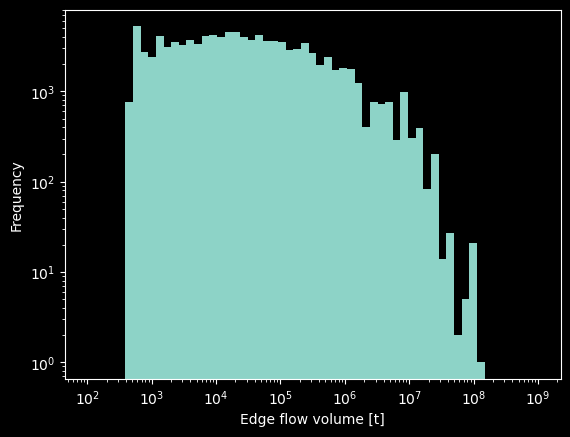

In [6]:
f, ax = plt.subplots()
min_non_zero = edges[edges.volume_tons != 0].volume_tons.min()
min_base_10_exp = int(np.floor(np.log10(min_non_zero)))
max_base_10_exp = int(np.ceil(np.log10(edges.volume_tons.max())))
ax.hist(
    edges.volume_tons,
    bins=np.logspace(
        min_base_10_exp,
        max_base_10_exp,
        60
    )
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Edge flow volume [t]")
ax.set_ylabel("Frequency")

       volume_t_km
mode              
rail  2.595771e+08
road  1.012927e+12


Text(0, 0.5, 'Volume [t] / Distance [km]')

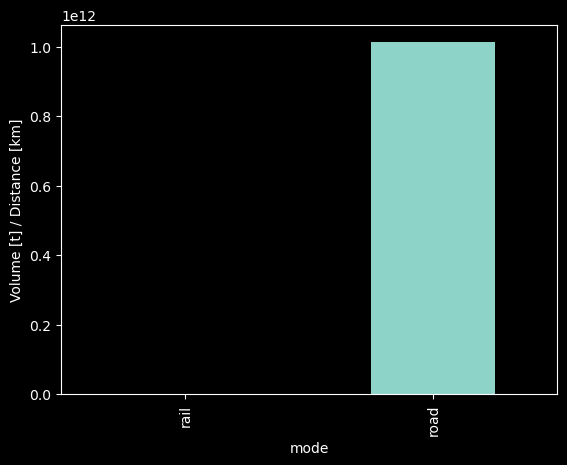

In [7]:
land_mask = edges["mode"].isin(("road", "rail"))
land = edges.loc[land_mask].copy()
land["distance_km"] = land["geometry"].to_crs(land.estimate_utm_crs()).length / 1000
land["volume_t_km"] = land.volume_tons / land.distance_km

modal_split = land.loc[:, ["volume_t_km"]].groupby(land["mode"]).sum()
print(modal_split)
f, ax = plt.subplots()
modal_split.volume_t_km.plot(kind="bar", ax=ax)
ax.set_ylabel("Volume [t] / Distance [km]")

In [8]:
def chop_at_antimeridian(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    Cut LineStrings either side of antimeridian, then drop the fragments that
        intersect with antimeridian.

    Warning: Will create new rows (split geometries) with duplicate indices.

    Args:
        gdf: Table with geometry to chop at antimeridian

    Returns:
        Table, potentially with new rows. No rows in the table should have
            geometries that cross the antimeridian.
    """
    assert set(gdf.geometry.type) == {'LineString'}
    
    def split_on_meridian(gdf: gpd.GeoDataFrame, meridian: shapely.geometry.LineString) -> gpd.GeoDataFrame:
        return gdf.assign(geometry=gdf.apply(lambda row: split(row.geometry, meridian), axis=1)).explode(index_parts=False)

    xlim = 179.9
    ylim = 90

    split_e = split_on_meridian(gdf, shapely.geometry.LineString([(xlim, ylim), (xlim, -ylim)]))
    split_e_and_w = split_on_meridian(split_e, shapely.geometry.LineString([(-xlim, ylim), (-xlim, -ylim)]))

    def crosses_antimeridian(row: pd.Series) -> bool:
        """
        Check if there are longitudes in a geometry that are near the antimeridian 
            (-180) and either side of it. If so, return true.
        """
        x, _ = row.geometry.coords.xy
        longitudes_near_antimeridian = np.array(x)[np.argwhere(np.abs(np.abs(x) - 180) < xlim).ravel()]
        if len(longitudes_near_antimeridian) == 0:
            return False
        hemispheres = np.unique(np.sign(longitudes_near_antimeridian))
        if (-1 in hemispheres) and (1 in hemispheres):
            return True
        else:
            return False

    return split_e_and_w[~split_e_and_w.apply(crosses_antimeridian, axis=1)]

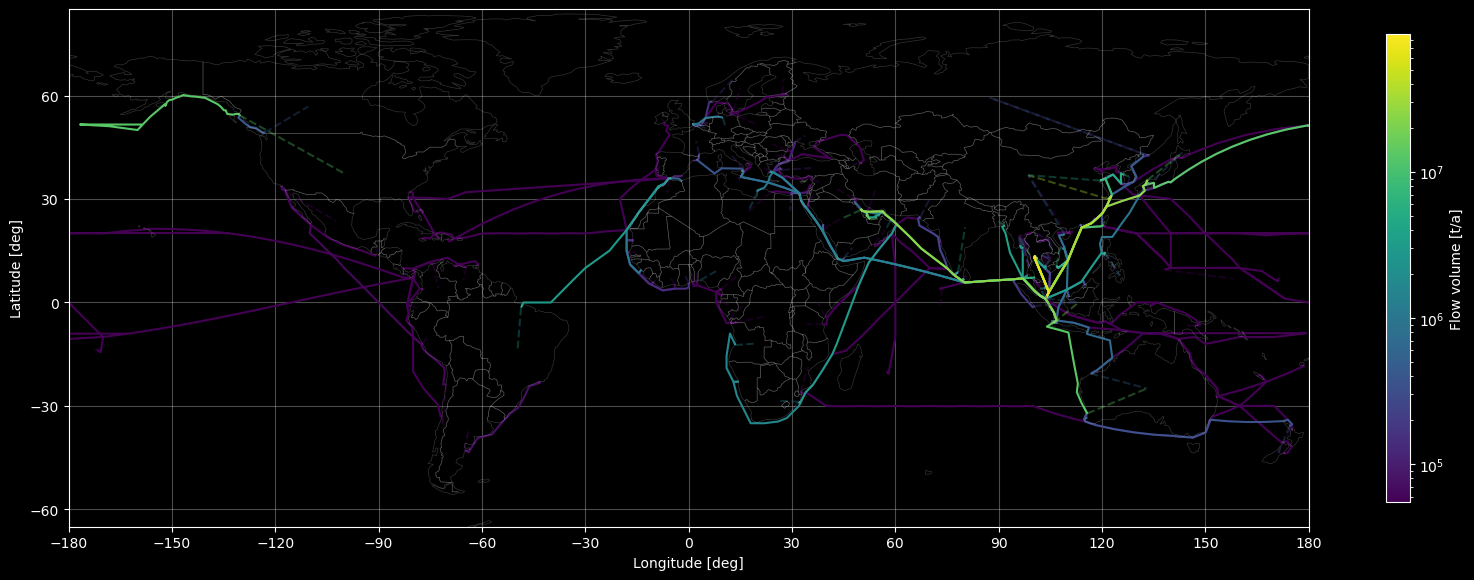

In [9]:
f, ax = plt.subplots(figsize=(20, 16))

edges_with_volume = edges[(edges.volume_tons != 0) & edges["mode"].isin({"maritime", "imaginary"})]
edges_with_volume_and_geometry = edges_with_volume[~edges_with_volume.geometry.isna()]
to_plot = chop_at_antimeridian(edges_with_volume_and_geometry)
not_imaginary_mask = to_plot["mode"] != "imaginary"

norm = LogNorm(10**np.log10(to_plot.volume_tons.quantile(0.5)), 10**np.log10(to_plot.volume_tons.max()))
crs_epsg: int = 4326

to_plot[not_imaginary_mask].sort_values("volume_tons").plot("volume_tons", ax=ax, norm=norm, legend=True, legend_kwds={"shrink": 0.38, "label": "Flow volume [t/a]"})
to_plot[~not_imaginary_mask].plot("volume_tons", ax=ax, norm=norm, ls="--", alpha=0.35)
world.plot(ax=ax, lw=0.5, alpha=0.2)
ax.set_xticks(np.linspace(-180, 180, 13))
ax.set_yticks([-60, -30, 0, 30, 60])
ax.set_ylim(-65, 85)
ax.set_xlim(-180, 180)
ax.grid(alpha=0.3)
ax.set_xlabel("Longitude [deg]")
ax.set_ylabel("Latitude [deg]")
f.savefig("trade_flow_allocation_global.png")

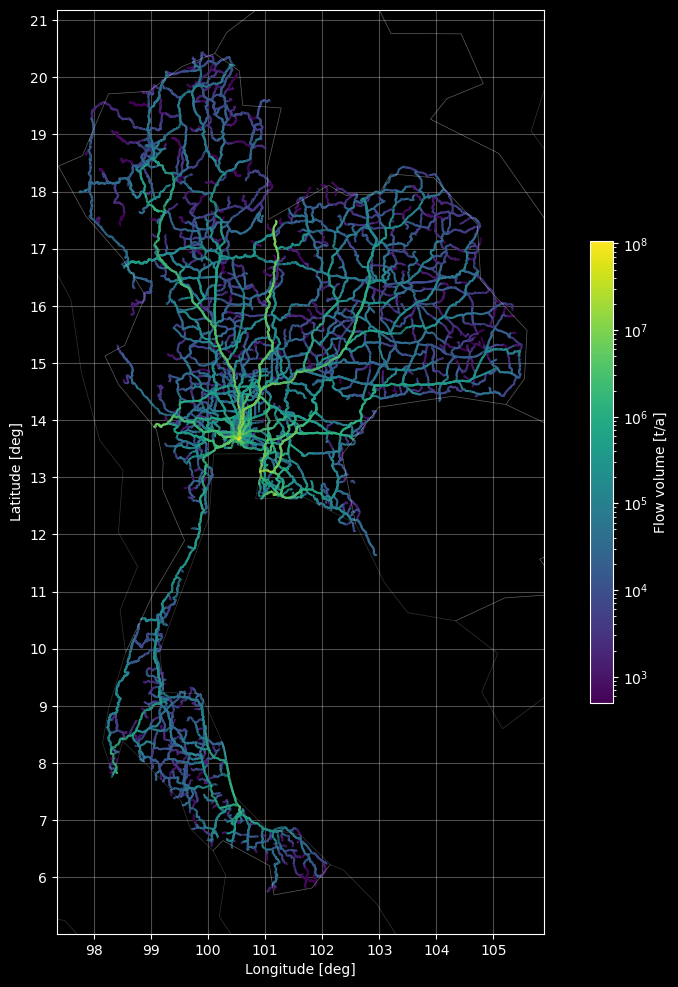

In [25]:
f, ax = plt.subplots(figsize=(12, 12))

to_plot = edges[
    (edges.volume_tons != 0) 
    & edges["mode"].isin(
        {
            'road_rail',
            'maritime_road',
            'maritime_rail',
            'road',
            'rail',
            #'maritime',
            #'imaginary'
        }
    )
]
not_imaginary_mask = to_plot["mode"] != "imaginary"
norm = LogNorm(10**np.log10(to_plot.volume_tons.min()), 10**np.log10(to_plot.volume_tons.max()))
to_plot[not_imaginary_mask].sort_values("volume_tons").plot(
    "volume_tons", ax=ax, legend=True, norm=norm, legend_kwds={"shrink": 0.5, "label": "Flow volume [t/a]"}
)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.set_yticks(range(5, 22))
ax.set_xticks(range(98, 106))
world.plot(ax=ax, lw=0.5, alpha=0.2)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.grid(alpha=0.3)
ax.set_xlabel("Longitude [deg]")
ax.set_ylabel("Latitude [deg]")
f.savefig("trade_flow_allocation_local.png")

In [12]:
routes_path = os.path.join(root_dir, "results/flow_allocation/project-thailand/routes.pq")
routes_with_edge_indices: pd.DataFrame = pd.read_parquet(routes_path)

cost_col_id = edges.columns.get_loc("cost_USD_t")
#geometry_col_id = edges.columns.get_loc("geometry")
routes_with_geometry = []
for index, route_data in tqdm(routes_with_edge_indices.iterrows(), total=len(routes_with_edge_indices)):
    source_node, destination_node = index
    
    # drop edges missing geometry (we expect these for within port connections
    #route_edge_geometry = edges.iloc[route_data["edge_indices"], geometry_col_id].dropna()
    #route_linestring = linemerge(list(route_edge_geometry))
    cost_USD_t = edges.iloc[route_data.edge_indices, cost_col_id].sum()
    if 1E6 < cost_USD_t < 2E6:
        cost_USD_t -= 1E6
    elif cost_USD_t == 0:
        pass
    else:
        # cost more than $2M USD means more than one $1M USD imaginary link -- not a valid route
        # discard these
        continue
    routes_with_geometry.append(
        (
            source_node,
            destination_node.split("_")[-1],
            route_data.value_kusd,
            route_data.volume_tons,
            cost_USD_t,
            #route_linestring
        )
    )

routes = pd.DataFrame(routes_with_geometry, columns=["source_node", "destination_node", "value_kusd", "volume_tons", "cost_USD_t"])#, "geometry"])
routes

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105350/105350 [00:30<00:00, 3418.08it/s]


,source_node,destination_node,value_kusd,volume_tons,cost_USD_t
0,thailand-latest_14_1063,CHN,1226.363050,594.420277,54.445056
1,thailand-latest_14_112,CHN,2492.417272,1617.163204,58.238449
2,thailand-latest_14_115,CHN,851.468350,540.894579,61.318649
3,thailand-latest_14_1196,CHN,1267.345033,822.101575,60.172588
4,thailand-latest_14_1199,CHN,1838.994334,796.304929,53.616253
...,...,...,...,...,...
105326,thailand-latest_43_1,CHN,3981.677957,3726.701347,25.007351
105327,thailand-latest_43_1,KHM,202.371643,591.722539,6.578314
105328,thailand-latest_43_1,LAO,264.166052,1069.103202,33.994855
105329,thailand-latest_43_1,MMR,325.814432,940.478485,26.508016


In [13]:
# we need at least the top 20 trading partners to get 90% of the trade volume
# here we only have 8 partners total (all in the top 20)
routes.loc[:, ["destination_node", "volume_tons"]].groupby("destination_node").sum().sort_values("volume_tons", ascending=False)

,volume_tons
destination_node,
CHN,3.937094e+07
IDN,2.310127e+07
ARE,1.528312e+07
JPN,1.383789e+07
AUS,1.381213e+07
...,...
MHL,1.256930e+03
JAM,1.248590e+03
HTI,1.223836e+03


In [14]:
volume_tons_by_country = routes.loc[:, ["destination_node", "volume_tons"]].groupby("destination_node").sum()
volume_tons_by_country.index.name = "GID_0"
# country boundaries for diagnostic plotting
countries = gpd.read_parquet(os.path.join(root_dir, "results/input/admin-boundaries/admin-level-0.geoparquet"))
volume_tons_by_country_with_geom = countries.set_index("GID_0", drop=True).join(volume_tons_by_country)

Text(0.5, 1.0, 'Partner country trade volume [t/a] post-allocation')

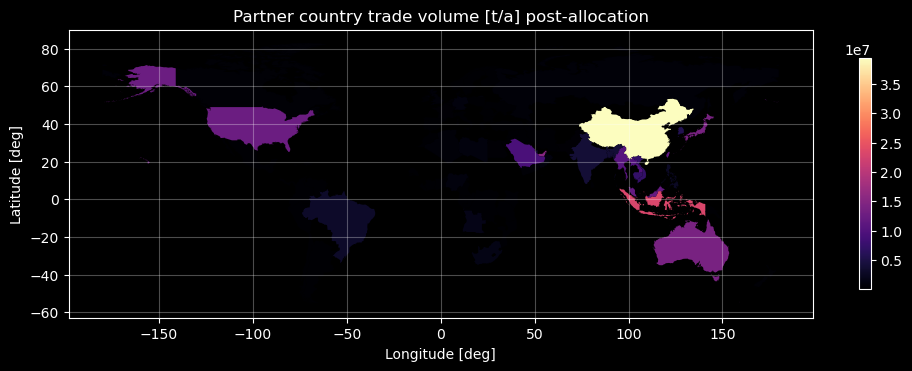

In [15]:
f, ax = plt.subplots(figsize=(12, 10))
volume_tons_by_country_with_geom.plot("volume_tons", ax=ax, legend=True, legend_kwds={"shrink": 0.3}, cmap="magma")
ax.grid(alpha=0.3)
ax.set_xlabel("Longitude [deg]")
ax.set_ylabel("Latitude [deg]")
ax.set_title("Partner country trade volume [t/a] post-allocation")